In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import datetime

#sns.set_style(style='darkgrid', rc=None)
plt.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

In [8]:
from functions import *
from viz import *

# 1. Data

### 1.1. Import, interpolate and exponentially smooth Commitments of Traders data

#### Create CoT data for three asset classes:

In [9]:
# import CoT data from .csv
us5yr_cot = pd.read_csv('C:/Users/Tom/Google Drive/asset-price-prediction/CoT Data/US5YR_interpolated.csv')
spx_cot = pd.read_csv('C:/Users/Tom/Google Drive/asset-price-prediction/CoT Data//SPX_interpolated.csv')
dxy_cot = pd.read_csv('C:/Users/Tom/Google Drive/asset-price-prediction/CoT Data//DXY_interpolated.csv')

# generate CoT dataframe from .csvs
cot_indicators_us5yr = generate_cot_data(us5yr_cot)
cot_indicators_spx = generate_cot_data(spx_cot)
cot_indicators_dxa = generate_cot_data(dxy_cot)

# drop more columns which are of no use:
for df in [cot_indicators_us5yr, cot_indicators_spx,
           cot_indicators_dxa]:
    df = df.drop(
        ['Pct_of_Open_Interest_All', 'Pct_of_Open_Interest_Old',
         'Pct_of_Open_Interest_Other'],
        axis=1, inplace=True)

#### create charts to demonstrate smoothed/unsmoothed data

In [10]:
# df1 = interpolate_missing(spx_cot)
# df2 = drop_unwanted_cols(df1)

# # create a df of just floats
# df_floats = df2.select_dtypes(include=['float64'])

In [11]:
# plot_charts(df_floats.iloc[:,0:6], dim1 = 2, dim2 = 3, fig_size = (10, 5), y_label="No. of Contracts")

In [6]:
# plot_charts(cot_indicators_spx.iloc[:,0:6], dim1 = 2, dim2 = 3, fig_size = (10, 5), y_label="No. of Contracts")

#### Plot all Commitment of Traderes data

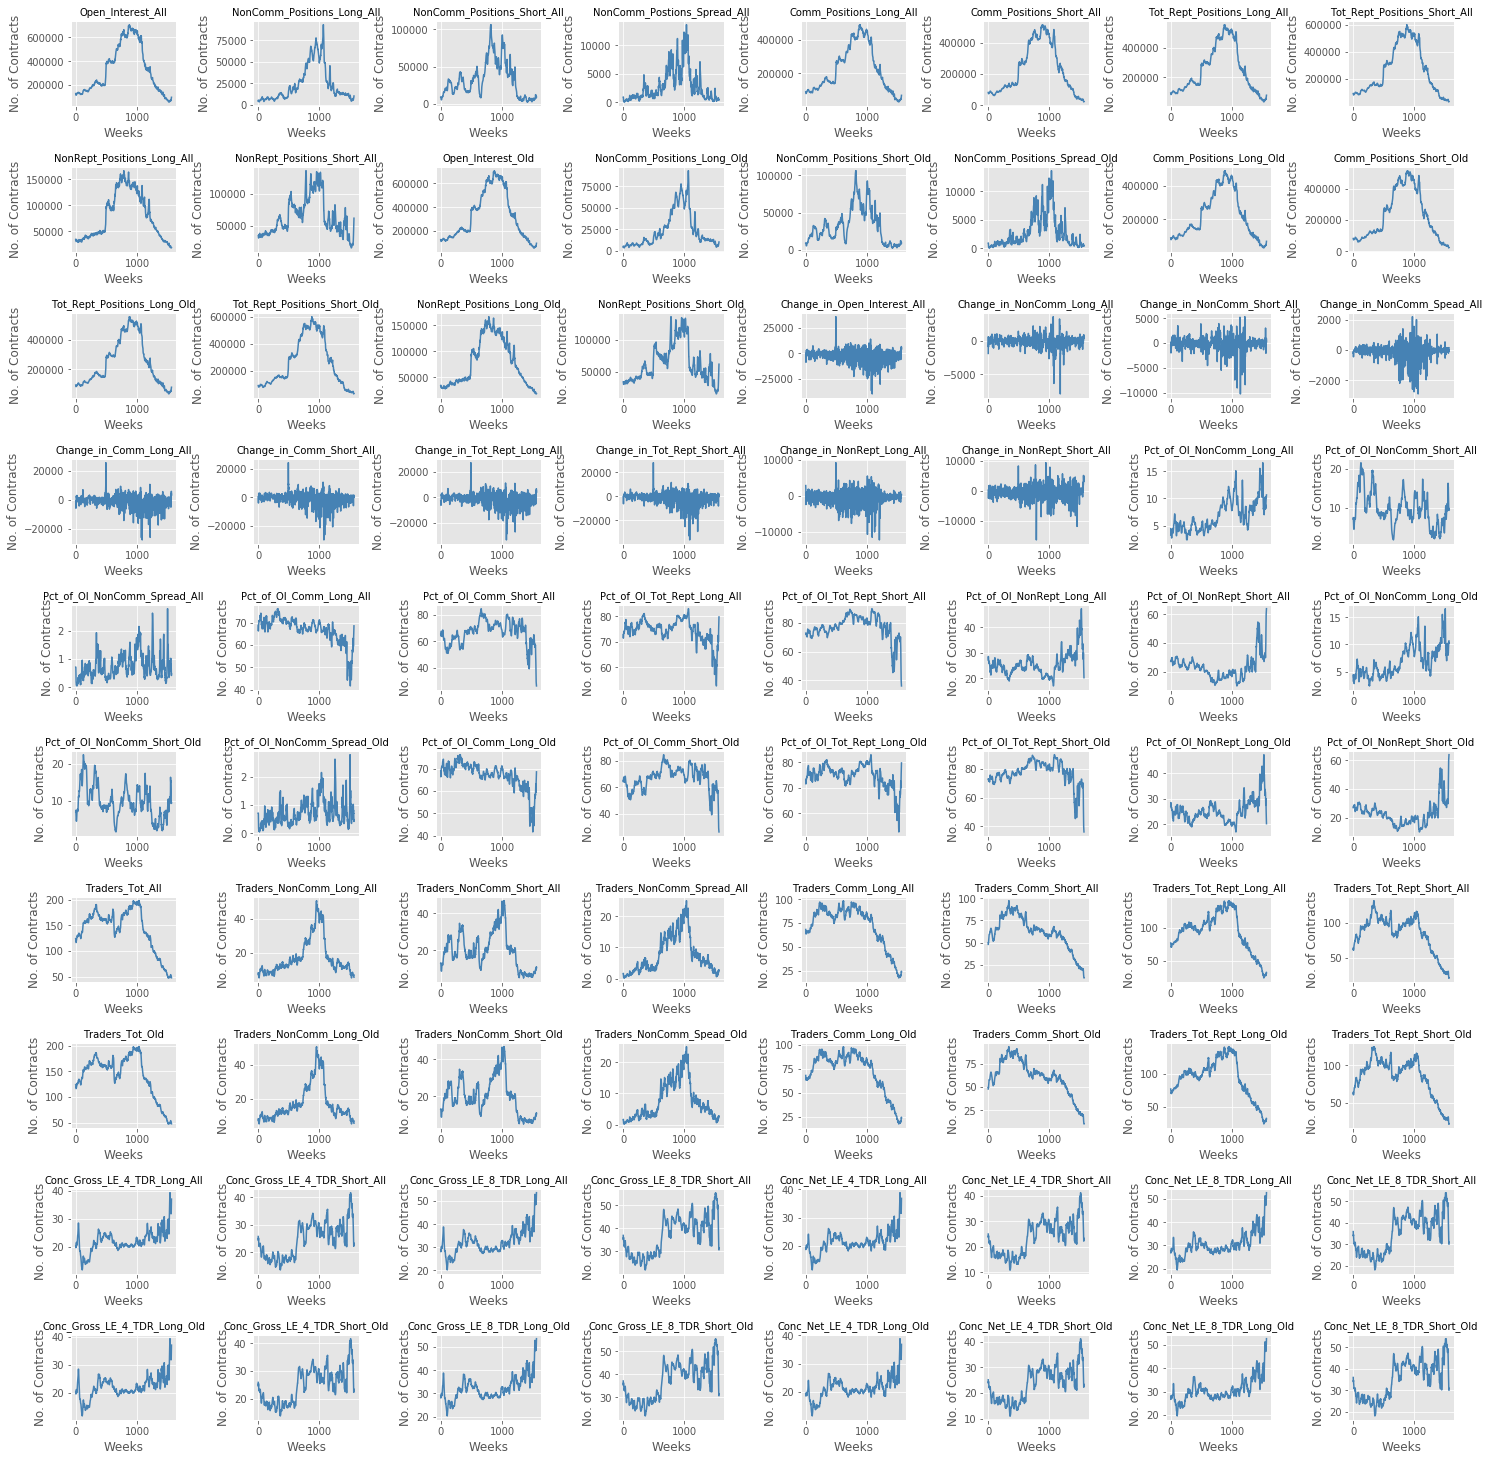

In [12]:
#plot S&P500 CoT charts
plot_charts(cot_indicators_spx, dim1 = 10, dim2 = 8,
            fig_size = (20, 20), y_label="No. of Contracts")

#### Generate new CoT features (net figures, change)

In [9]:
# generate refined CoT features
cot_indicators_spx_refined = refined_cot_data(cot_indicators_spx)
cot_indicators_dxa_refined = refined_cot_data(cot_indicators_dxa)
cot_indicators_us5yr_refined = refined_cot_data(cot_indicators_us5yr)

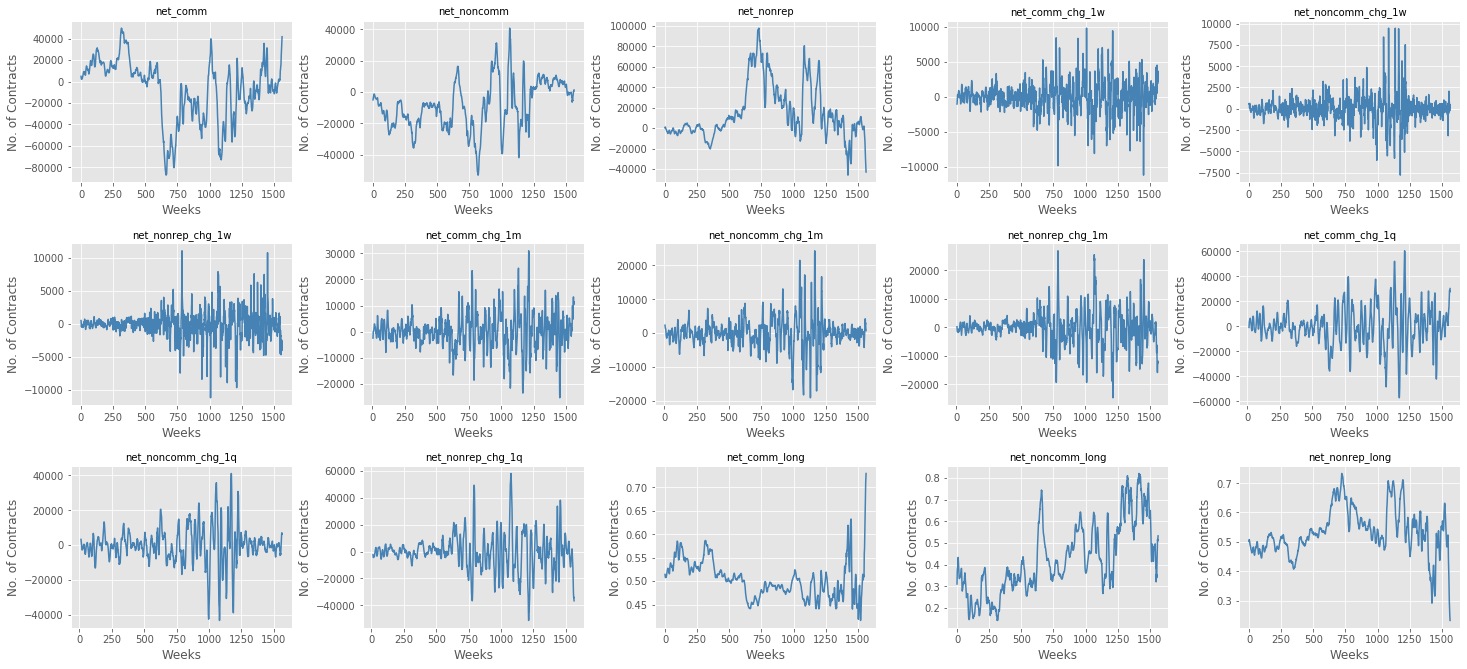

In [10]:
# plot generated SPX CoT features
plot_charts(cot_indicators_spx_refined, dim1 = 3, dim2 = 5,
            fig_size = (20, 9), y_label="No. of Contracts")

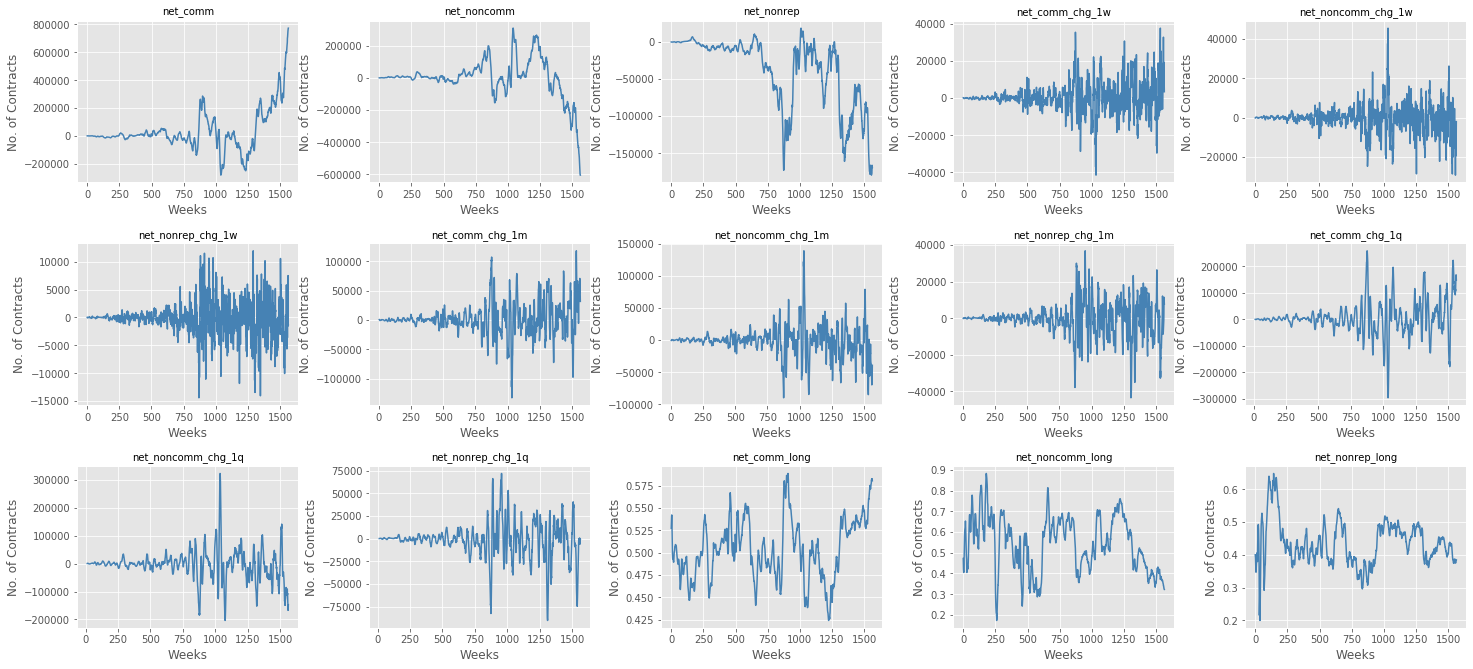

In [11]:
# plot generated US5YR CoT features
plot_charts(cot_indicators_us5yr_refined, dim1 = 3, dim2 = 5,
            fig_size = (20, 9), y_label="No. of Contracts")

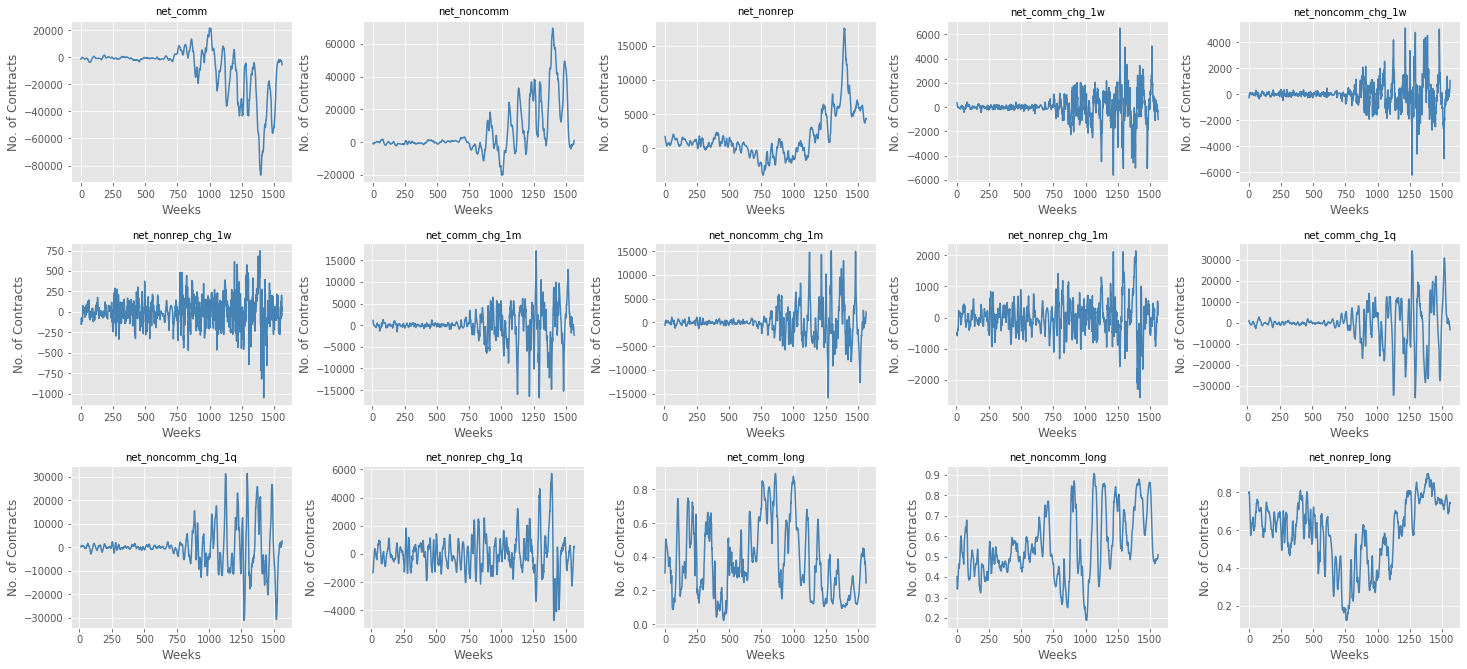

In [12]:
# plot generated DXA CoT features
plot_charts(cot_indicators_dxa_refined, dim1 = 3, dim2 = 5, fig_size = (20, 9), y_label="No. of Contracts")

### 1.2. Import macroeconomic fundamental data and create additional features

In [13]:
# Start date: 05/01/1990
# read in data
m1 = pd.read_csv("C:/Users/Tom/Google Drive/asset-price-prediction/Economic Data/M1 v2.csv") # M1 money supply
t10y2y = pd.read_csv("C:/Users/Tom/Google Drive/asset-price-prediction/Economic Data/T10Y2Y v2.csv") # 10 year - 2 year interest rate differential
vix = pd.read_csv("C:/Users/Tom/Google Drive/asset-price-prediction/Economic Data/VIXCLS.csv") # VIX index
epu = pd.read_csv("C:/Users/Tom/Google Drive/asset-price-prediction/Economic Data/EPU.csv") # Economic policy uncertainty
dxy = pd.read_csv("C:/Users/Tom/Google Drive/asset-price-prediction/Economic Data/DXY_index.csv") # US Dollar
wti = pd.read_csv("C:/Users/Tom/Google Drive/asset-price-prediction/Economic Data/WTI.csv") # WTI crude oil
gld = pd.read_csv("C:/Users/Tom/Google Drive/asset-price-prediction/Economic Data/GOLD.csv") # Gold
spy = pd.read_csv("C:/Users/Tom/Google Drive/asset-price-prediction/Economic Data/SPY.csv") # S&P500 index

In [14]:
# merge the indicators into a single dataframe
m1 = m1.drop('DATE', axis = 1)
macro_indicators = pd.concat(
    [m1, t10y2y], join='outer', axis=1) # concatenate M1 and yield spreads

# merge the additional economic series
dfs_to_merge = [macro_indicators, vix, dxy, wti, gld, spy, epu]

# apply merge to dataframes in list
macro_indicators = reduce(lambda df1, df2: \
                          pd.merge(df1,
                                   df2,
                                   left_on='DATE',
                                   right_on='DATE',
                                   how='right'), dfs_to_merge)

# smooth the series to remove noise (5 week smoothing)
macro_indicators['epu_smoothed'] = smoothSeries(epu.EPU, 25)

In [16]:
cols_to_transform = ['M1', 'T10Y2Y', 'VIX', 'DXY', 'WTI', 'GLD', 'SPY']

# create columns that show 1-week change
macro_indicators = create_returns_variables(
    df=macro_indicators,
    cols=cols_to_transform,
    period_weeks=1,
    string_append="_chg_1w")

# create columns that show 4-week change
macro_indicators = create_returns_variables(
    df=macro_indicators,
    cols=cols_to_transform,
    period_weeks=4,
    string_append="_chg_1m")

# create columns that show 12-week change
macro_indicators = create_returns_variables(
    df=macro_indicators,
    cols=cols_to_transform,
    period_weeks=12,
    string_append="_chg_1q")

Create binary variables that indicate whether a
    features' values are above their moving averages.

In [18]:
# Create binary indicators that indicates whether VIX and EPU > moving average
macro_indicators = create_binary_variables(df=macro_indicators,
                                           cols_to_binarise=['VIX', 'EPU'])

Text(0.5, 15.0, 'Weeks')

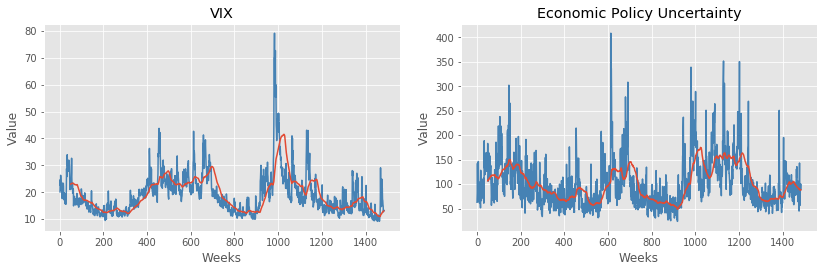

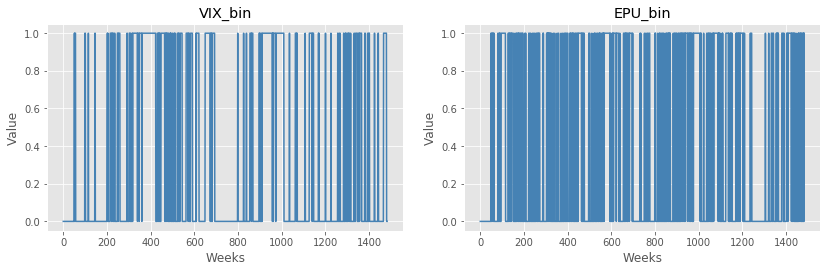

In [19]:
# plot the indicators
fig, axs = plt.subplots(1, 2, figsize= (12, 4))
fig.tight_layout(pad=3)
axs = axs.ravel()

axs[0].plot(macro_indicators['VIX'], color='steelblue')
axs[0].set_title("VIX")
axs[0].plot(macro_indicators['VIX'].rolling(50).mean())
axs[0].set_ylabel("Value")
axs[0].set_xlabel("Weeks")

axs[1].plot(macro_indicators['EPU'], color='steelblue')
axs[1].set_title("Economic Policy Uncertainty")
axs[1].plot(macro_indicators['EPU'].rolling(50).mean())
axs[1].set_ylabel("Value")
axs[1].set_xlabel("Weeks")

fig, axs = plt.subplots(1, 2, figsize= (12, 4))
fig.tight_layout(pad=3)
axs = axs.ravel()

axs[0].plot(macro_indicators['VIX_bin'], color='steelblue')
axs[0].set_title("VIX_bin")
axs[0].set_ylabel("Value")
axs[0].set_xlabel("Weeks")

axs[1].plot(macro_indicators['EPU_bin'], color='steelblue')
axs[1].set_title("EPU_bin")
axs[1].set_ylabel("Value")
axs[1].set_xlabel("Weeks")

### 1.3. Seasonal pattern indicator

In [20]:
# one-hot encoded binary variables to indicate month of the year 

# dayfirst = True, because original data is in DD/MM/YYYY format
macro_indicators['DATE'] = pd.to_datetime(
    macro_indicators['DATE'], dayfirst=True)

# extract the month from datetime objects
macro_indicators['Month'] = macro_indicators['DATE'].dt.month

# Create one-hot columns for the months
# Set drop_first to true otherwise the dummy trap appears!
cols = ['Month']
macro_indicators = pd.get_dummies(
    macro_indicators, columns=cols, drop_first=True)

### 1.4. Create technical indicators

As per Khaidem et al., historical data is exponentially smoothed before creating the technical indicators/features.

*"This smoothing removes random variation or noise from the historical data allowing the model to easily identify long term price trend in the stock price behavior."*

#### Read in the SPX, DXA and US5YR data from bloomberg to calculate technical indicators

In [25]:
spx_path =  "C:/Users/Tom/Google Drive/asset-price-prediction/BBG data/values/esa_friday.csv"
us5yr_path =  "C:/Users/Tom/Google Drive/asset-price-prediction/BBG data/values/fva_friday.csv"
dxy_path =  "C:/Users/Tom/Google Drive/asset-price-prediction/BBG data/values/dxa_friday.csv"

# create indicators for the 3 asset classes
technical_indicators_spx = create_technical_indicators(path=spx_path)
technical_indicators_us5yr = create_technical_indicators(path=us5yr_path)
technical_indicators_dxy = create_technical_indicators(path=dxy_path)

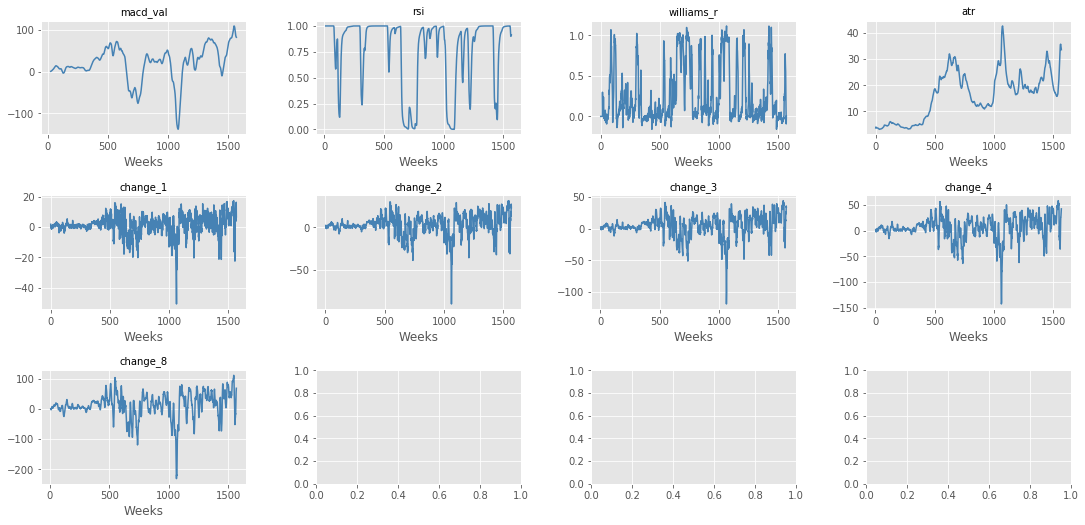

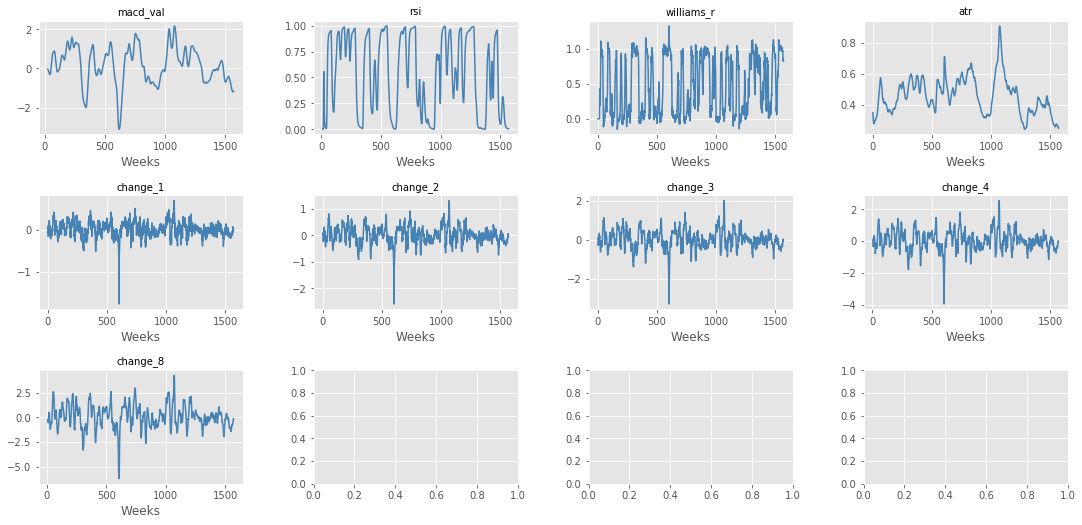

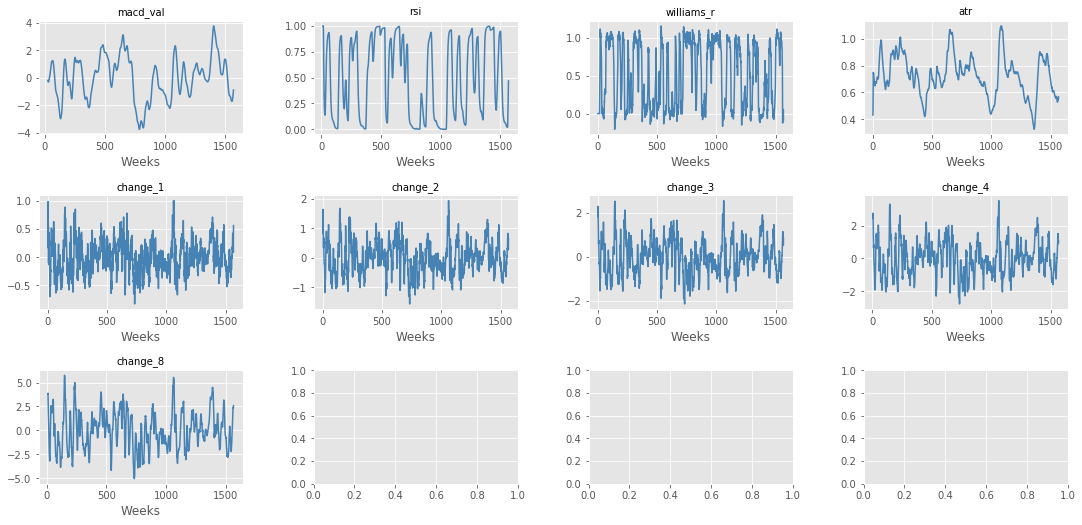

In [26]:
# plot the technical indicators 
assets = {
    'spx': technical_indicators_spx,
    'us5yr': technical_indicators_us5yr,
    'dxy': technical_indicators_dxy
}

for a in assets:
    plot_charts(assets[a][
        ['macd_val', 'rsi', 'williams_r', 'atr', 'change_1',
         'change_2', 'change_3', 'change_4', 'change_8']
    ], dim1 = 3, dim2 = 4, fig_size=(15,7))

#### Binary technical indicators - indication of trend

In [28]:
# SPX: Add the binary indicators to the 'technical_indicators' dataframe:
technical_indicators_spx_binary = create_binary_indicators(
    technical_indicators_spx)

# US5YR: Add the binary indicators to the 'technical_indicators' dataframe:
technical_indicators_us5yr_binary = create_binary_indicators(
    technical_indicators_us5yr)

# DXA: Add the binary indicators to the 'technical_indicators' dataframe:
technical_indicators_dxa_binary = create_binary_indicators(technical_indicators_dxy)

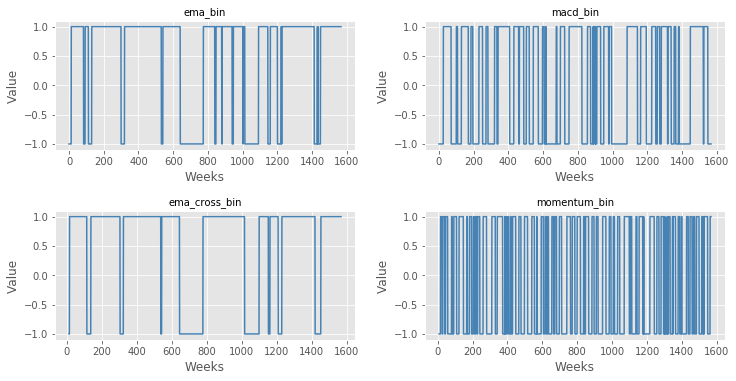

In [29]:
# plot the newly created binary variables
plot_charts(technical_indicators_spx_binary[
    ['ema_bin', 'macd_bin', 'ema_cross_bin', 'momentum_bin']
], dim1 = 2, dim2 = 2, fig_size=(10,5), y_label="Value")

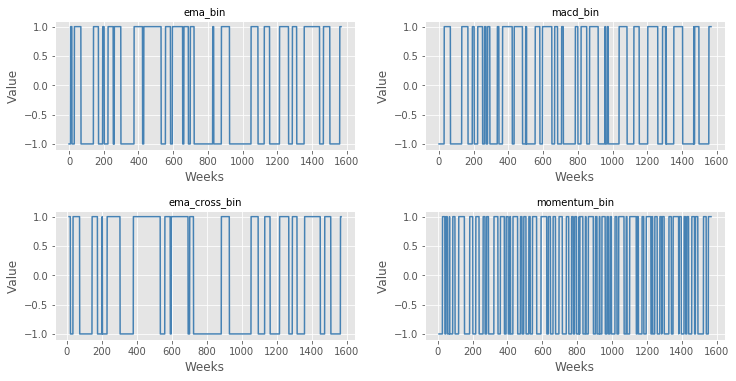

In [30]:
plot_charts(technical_indicators_dxa_binary[
    ['ema_bin', 'macd_bin', 'ema_cross_bin', 'momentum_bin']
], dim1 = 2, dim2 = 2, fig_size=(10,5), y_label="Value")

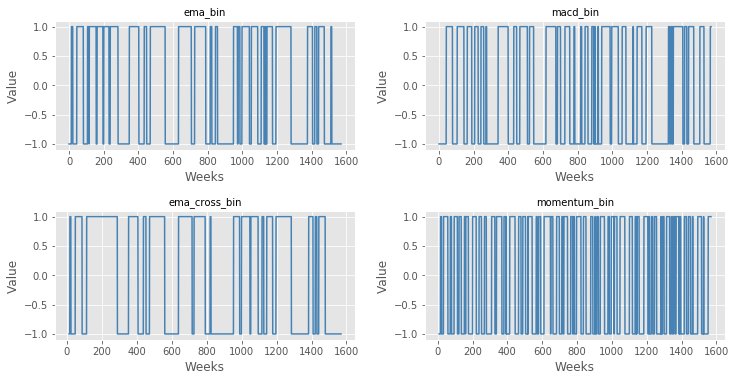

In [31]:
plot_charts(technical_indicators_us5yr_binary[
    ['ema_bin', 'macd_bin', 'ema_cross_bin', 'momentum_bin']
], dim1 = 2, dim2 = 2, fig_size=(10,5), y_label="Value")

### 1.5. Join relevant CoT data, macro data and technical indicators 

#### SPX

In [32]:
# spx data starts at 1988-06-03 i.e. 3rd June 1988.
# CoT data starts at 1988-05-31 i.e. 31st May 1988.

# spx data ends at 2018-06-15 i.e. 3rd June 2018.
# CoT data ends at 2018-05-22 i.e. 31st May 2018.

# append a correct date column to CoT data by

# a) removing 1 row from start of CoT
cot_indicators_spx_refined = cot_indicators_spx_refined.iloc[1:,:]

# b) removing 3 rows from the end of spx Date column
date_col = technical_indicators_spx.Date[:-3] # 77 is index for week at which CoT data starts
date_col.reset_index(drop=True, inplace=True) # reset the index otherwise concatenate won't work
date_col = pd.to_datetime(date_col, dayfirst=True)

# c) append the date to CoT indicators
cot_indicators_spx = pd.concat(
    [date_col, cot_indicators_spx_refined],
    join = 'outer', axis=1) # CoT data with date attached

# join CoT indicators with macro indicators
inputs_spx = pd.merge(
    left=cot_indicators_spx,
    right=macro_indicators,
    left_on='Date',
    right_on='DATE',
    how = 'outer') 

inputs_spx = inputs_spx.drop(['DATE'], axis = 1)

# join CoT indicators + macro indicators with technical indicators
inputs_spx = pd.merge(
    inputs_spx,
    technical_indicators_spx_binary[
        ['Date', 'ema_bin', 'macd_bin', 'ema_cross_bin', 'momentum_bin',
         'change_1', 'change_2', 'change_3', 'change_8']], on='Date')

# join CoT indicators + macro indicators with technical indicators
inputs_spx = pd.merge(inputs_spx, technical_indicators_spx[
    ['Date', 'macd_val', 'rsi', 'williams_r', 'atr', 'change_1',
     'change_2', 'change_3', 'change_4', 'change_8']
], on='Date')

#### US5YR

In [33]:
# us5yr data starts at 1989-07-14 i.e. 14th July 1989.
# CoT data starts at 1988-05-31 i.e. 31st May 1988.
# us5yr technical ind. starts at 1988-07-14

# us5yr data ends at 2018-06-15 i.e. 29 June 2018.
# CoT data ends at 2018-05-22 i.e. 22nd May 2018.
# us5yr technical ind. ends at 2018-06-29

# append a correct date column to CoT data by

# a) removing n rows from start of CoT to line up with us5yr data... 14 July 1989 is index 58 in us5yr_cot

cot_indicators_us5yr_refined = cot_indicators_us5yr_refined.iloc[58:,:]
cot_indicators_us5yr_refined= cot_indicators_us5yr_refined.reset_index(drop=True)

# b) removing 4 rows from the end of us5yr Date column
date_col = technical_indicators_us5yr.Date[:-5]
date_col.reset_index(drop=True, inplace=True) # reset the index otherwise concatenate won't work
date_col = pd.to_datetime(date_col, dayfirst=True)
date_col = pd.DataFrame(date_col)

# c) append the date to CoT indicators
cot_indicators_us5yr = pd.concat(
    [date_col, cot_indicators_us5yr_refined],
    join = 'outer',
    axis=1) # CoT data with date attached

inputs_us5yr = pd.merge(
    left=cot_indicators_us5yr,
    right=macro_indicators,
    left_on='Date',
    right_on='DATE',
    how = 'outer') # join CoT indicators with macro indicators

inputs_us5yr = inputs_us5yr.drop(['DATE'], axis = 1)

# join CoT indicators + macro indicators with technical indicators
inputs_us5yr = pd.merge(
    inputs_us5yr,
    technical_indicators_us5yr_binary[
        ['Date', 'ema_bin', 'macd_bin', 'ema_cross_bin', 'momentum_bin',
         'change_1', 'change_2', 'change_3', 'change_8']], on='Date')

# join CoT indicators + macro indicators with technical indicators
inputs_us5yr = pd.merge(
    inputs_us5yr,
    technical_indicators_us5yr[
        ['Date', 'macd_val', 'rsi', 'williams_r', 'atr', 'change_1',
         'change_2', 'change_3', 'change_4', 'change_8']], on='Date')

#### DXA

In [34]:
# dxa data starts at 1988-06-03 i.e. 3rd June 1988.
# CoT data starts at 1988-05-31 i.e. 31st May 1988.

# dxa data ends at 2018-06-15 i.e. 3rd June 2018.
# CoT data ends at 2018-05-22 i.e. 31st May 2018.

# append a correct date column to CoT data by

# a) removing 1 row from start of CoT
cot_indicators_dxa_refined = cot_indicators_dxa_refined.iloc[1:,:]

# b) removing 3 rows from the end of dxa Date column
date_col = technical_indicators_dxy.Date[:-3] # 77 is index for week at which CoT data starts
date_col.reset_index(drop=True, inplace=True) # reset the index otherwise concatenate won't work
date_col = pd.to_datetime(date_col, dayfirst=True)

# c) append the date to CoT indicators
cot_indicators_dxa = pd.concat(
    [date_col, cot_indicators_dxa_refined],
    join = 'outer', axis=1) # CoT data with date attached

inputs_dxa = pd.merge(
    left=cot_indicators_dxa,
    right=macro_indicators,
    left_on='Date',
    right_on='DATE',
    how = 'outer') # join CoT indicators with macro indicators

inputs_dxa = inputs_dxa.drop(['DATE'], axis = 1)

# join CoT indicators + macro indicators with technical indicators
inputs_dxa = pd.merge(inputs_dxa, technical_indicators_dxa_binary[
    ['Date', 'ema_bin', 'macd_bin', 'ema_cross_bin', 'momentum_bin',
     'change_1', 'change_2', 'change_3', 'change_8']], on='Date')

# join CoT indicators + macro indicators with technical indicators
inputs_dxa = pd.merge(inputs_dxa, technical_indicators_dxy[
    ['Date', 'macd_val', 'rsi', 'williams_r', 'atr', 'change_1',
     'change_2', 'change_3', 'change_4', 'change_8']], on='Date')

### 1.6 create lagged variables

In [35]:
# select the columns for which we want to lag
cols = ['net_comm', 'net_noncomm', 'net_nonrep', 'net_comm_chg_1w',
        'net_noncomm_chg_1w', 'net_nonrep_chg_1w', 'net_comm_chg_1m',
        'net_noncomm_chg_1m', 'net_nonrep_chg_1m', 'net_comm_chg_1q',
        'net_noncomm_chg_1q', 'net_nonrep_chg_1q', 'net_comm_long',
        'net_noncomm_long', 'net_nonrep_long', 'M1', 'T10Y2Y', 'VIX',
        'EPU', 'DXY', 'SPY', 'epu_smoothed', 'M1_chg_1w', 'T10Y2Y_chg_1w',
        'VIX_chg_1w', 'M1_chg_1m', 'T10Y2Y_chg_1m', 'VIX_chg_1m',
        'M1_chg_1q', 'T10Y2Y_chg_1q', 'VIX_chg_1q', 'DXY_chg_1w',
        'DXY_chg_1m', 'DXY_chg_1q', 'SPY_chg_1w', 'SPY_chg_1m',
        'SPY_chg_1q']

In [37]:
inputs_spx = create_lagged_features(df=inputs_spx, cols_to_lag=cols)
inputs_us5yr = create_lagged_features(df=inputs_us5yr, cols_to_lag=cols)
inputs_dxa = create_lagged_features(df=inputs_dxa, cols_to_lag=cols)

## 1.7 Generate target variables
Binary variables indicating whether asset price rose or fell over a defined period (default is 4 weeks).



### SPX

In [40]:
spx_target = create_target_variable(
    path="C:/Users/Tom/Google Drive/asset-price-prediction/BBG data/values/esa_friday.csv",
    weeks=4)

fva_target = create_target_variable(
    path="C:/Users/Tom/Google Drive/asset-price-prediction/BBG data/values/fva_friday.csv",
    weeks=4)

dxa_target = create_target_variable(
    path="C:/Users/Tom/Google Drive/asset-price-prediction/BBG data/values/dxa_friday.csv",
    weeks=4)

# join the targets to the input data on date
inputs_spx = pd.merge(inputs_spx, spx_target, on='Date').dropna(how='any', axis=0)
inputs_us5yr = pd.merge(inputs_us5yr, fva_target, on='Date').dropna(how='any', axis=0)
inputs_dxa = pd.merge(inputs_dxa, dxa_target, on='Date').dropna(how='any', axis=0)

# remove columns that might give classifier the answer
# for example, DXA price might help SPX prediction, but shouldn't be in DXA inputs
# identify columns with DXY
cols_to_drop = inputs_spx.filter(like='SPY').columns
# drop them
inputs_spx= inputs_spx.drop(cols_to_drop, axis=1)

# identify columns with DXY
cols_to_drop = inputs_dxa.filter(like='DXY').columns
# drop them
inputs_dxa= inputs_dxa.drop(cols_to_drop, axis=1)

# Drop columns with _y for all assets
cols_to_drop = inputs_spx.filter(like='_y').columns
inputs_spx= inputs_spx.drop(cols_to_drop, axis=1)

cols_to_drop = inputs_us5yr.filter(like='_y').columns
inputs_us5yr= inputs_us5yr.drop(cols_to_drop, axis=1)

cols_to_drop = inputs_dxa.filter(like='_y').columns
inputs_dxa= inputs_dxa.drop(cols_to_drop, axis=1)

found esa in path
found fva in path
found dxa in path


### Set up X and y matrices and vectors for next stage

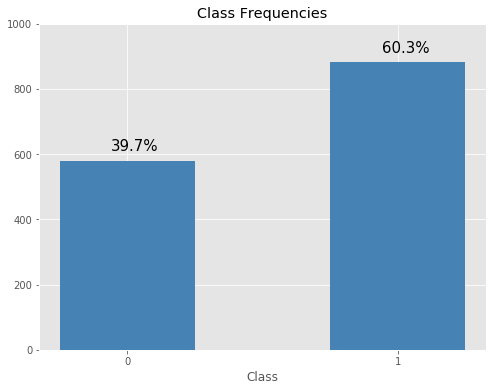

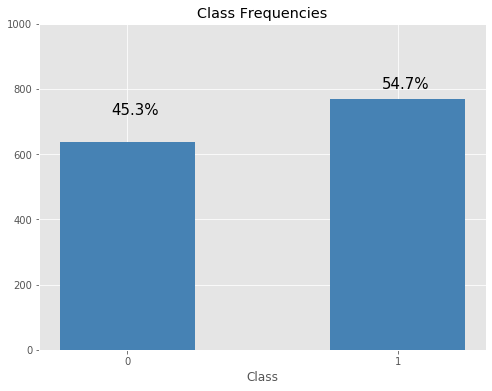

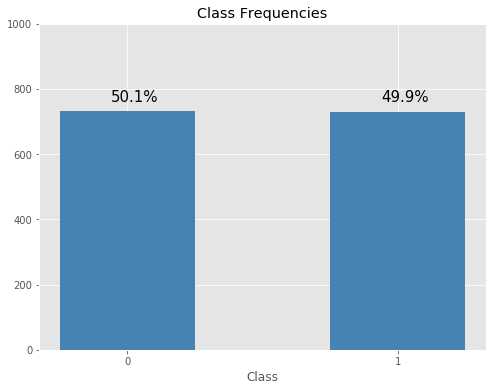

In [102]:
X_spx, y_spx = create_x_y(df=inputs_spx)
plot_class_frequencies(y_spx)

X_us5yr, y_us5yr = create_x_y(df=inputs_us5yr)
plot_class_frequencies(y_us5yr)

X_dxa, y_dxa = create_x_y(df=inputs_dxa)
plot_class_frequencies(y_dxa)

In [ ]:
%store inputs_spx
%store inputs_us5yr
%store inputs_dxa

%store X_spx
%store X_us5yr
%store X_dxa

%store y_spx
%store y_us5yr
%store y_dxa